# The Docker Engine
You can use Docker without understanding any of the things in this chapter.
However,you need to understand what's going under the hood to be a real Docker master
This chapter is theory based, with no hands on exercies

As this chapapter is part of the technical section of the book, we’re going to employ the three-tiered approach
where we split the chapter into three sections:
2. TLDR
3. Deep Dive
4. Commands

## The TLDR
The Docker Engine is the core software that runs and manages containers -> Simply: Docker
It is modular in design and built from many small specialised tools to create, run containers - APIs, execution driver, runtimes, shims, etc.

In [3]:
Where possiple, these are based on open standards such as those maintain by Open Container Initiative - OCI
At the time of writing, the major components that make up the Docker Engine are:
1. Docker Deamon
2. containerd
3. runc
4. Plugins: networking, storage, etc.


from 1,2,3,4 they create and run containers

<img src="figure51.png" width=1920 height=1080 />

$$ Figure\ 5.1\ High\ level\ view $$

SyntaxError: invalid syntax (707667415.py, line 1)

runc and containerd are lower-case is intentional, not mistake -> they will not start with capital letter 

# The Deep Dive
When Docker first released, it had two major components:
1. The Docker deamon - the deamon
2. LXC


###### The deamon
all of the code for:
1. Docker Client
2. Docker API
3. Container runtime
4. Image Builds
5. Much more
###### LXC
Provide daemon with access to the fundamental building-blocks of containers that existed in the Linux kernel.
Likes: namespace and control groups - cgroups

<img src="figure52.png" width=642 height=792 />

$$ Figure\ 5.2\ Original\ Docker\ Architecture $$

#### Getting rid of LXC
The reliance of LXC was an issue from the start
1. LXC is Linux-specific. This was a problem for a project that had aspirations of being multi-platform.
2. being reliant on an external tool for something so core to the project was a huge risk that could hinder development

As a result, Docker. Inc. developed their own tool: libcontainer -> replacement for LXC
###### lincontainer was to be a platform-agnostic tool that provided Docker with access to the fundamental container building-blocks that exist in the host kernel
Lincontainer replaced LXC as default execution driver in Docker 0.9

####  Getting rid of monolithic Docker Deamon
Problems:
1. It's hard to innovate on
2. It got slower
3. It wasn't the ecosystem wanted
Docker, Inc. was aware of these challenges and began a huge effort to break apart the monolithic daemon and
modularize it.
The aim of this work was to break out as much of the functionality as possible from the deamon, and re-implement it in smaller specialized tools.
These specialized tools can be swapped out, easy to re-use by third parties to build other tools
This work of breaking apart and re-factoring the Docker engine has seen all of the container execution and
container runtime code entirely removed from the daemon and refactored into small, specialized tools.
<img src="figure53.png" width=1920 height=1080 />

$$ Figure\ 5.3\ A\ high\ level\ view\ of\ current\ Docker\ Engine\ with\ brief\ descriptions$$


#### The influence of the Open Container Initiative (OCI)
While Docker, Inc. was breaking the daemon apart and refactoring code, the OCI was in the process of defining
two container-related specifications (a.k.a. standards):
1. Image spec
2. Container runtime spec


we shouldn’t see too much change, as stability is the name of the game here.
Docker, Inc. was heavily involved in creating these specifications and contributed a lot of code.
For example, the Docker daemon no longer contains any container runtime code — all container runtime code is
implemented in a separate OCI-compliant layer. By default, Doer uses runc for this. runc is the reference
implementation of the OCI container-runtime-spec.

##### runc
runc is the reference implementation of the OCI container-runtime-spec.
runc is a small, lightweight CLI wrapper for libcontainer (remember that
libcontainer originally replaced LXC as the interface layer with the host OS in the early Doer aritecture).
runc has a single purpose in life — create containers. 
And it’s damn good at it. And fast! But as it’s a CLI wrapper,
it’s effectively a standalone container runtime tool. Tis means you can download and build the binary, and you’ll
have everything you need to build and play with runc (OCI) containers. 
But it’s bare bones and very low-level, meaning you’ll have none of the richness that you get with the full-blown Docker engine.

##### containerd (pronounced container-dee)
As part of the effort to strip functionality out of the Docker daemon, all of the container execution logic was
ripped out and refactored into a new tool called containerd.
Its sole purpose in life was to manage container lifecycle operations — start | stop | pause | rm....

In the Docker engine stack, containerd sits between the daemon and runc at the OCI layer.

###### As previously stated, containerd was originally intended to be small, lightweight, and designed for a single task in life — container lifecycle operations.
However, over time it has branched out and taken on more functionality.
things like image pulls, volumes and networks.
One of the reasons for adding more functionality is to make it easier to use in other projects.
For these reasons, containerd now does a lot more than simple container lifecycle management. However, all the extra
functionality is modular and optional, meaning you can pick and choose which bits you want.
At the time of writing, containerd is a fully graduated CNCF project, meaning it’s stable and considered ready for
production.

#### Starting a new container (example)
The most common way of starting containers is using the Docker CLI.
> docker container run --name ctrl -it alpine:latest sh

When you type commands like this into the Docker CLI, the Docker client converts them into the appropriate
API payload and POSTs them to the API endpoint exposed by the Docker daemon.
The API is implemented in the daemon and can be exposed over a local socket or the network. On Linux the
socket is /var/run/docker.sock and on Windows it’s \pipe\docker_engine.
Once the daemon receives the command to create a new container, it makes a call to containerd. Remember that
the daemon no-longer contains any code to create containers!

The daemon communicates with containerd via a CRUD-style API over gRPC.

Despite its name, containerd cannot actually create containers. It uses runc to do that. It converts the required
Docker image into an OCI bundle and tells runc to use this to create a new container.

Despite its name, containerd cannot actually create containers. It uses runc to do that. It converts the required
Docker image into an OCI bundle and tells runc to use this to create a new container.

<img src="figure54.png" width=1920 height=1080 />

$$ Figure\ 5.4\ Summarization\ of\ the\ process$$


##### Benefit
Having all of the logic and code to start and manage containers removed from the daemon means that the entire
container runtime is decoupled from the Docker daemon. We sometimes call this “daemonless containers”, and
it makes it possible to perform maintenance and upgrades on the Docker daemon without impacting running
containers!

In the old model, where all of container runtime logic was implemented in the daemon, starting and stopping
the daemon would kill all running containers on the host. This was a huge problem in production environments
— especially when you consider how frequently new versions of Doer are released! Every daemon upgrade
would kill all containers on that host — not good!

Fortunately, this is no longer a problem.


#### Shim
Some of the diagrams in the chapter have shown a shim component.

The shim is integral to the implementation of daemonless containers - decoupling
running containers from the daemon for things like daemon upgrades).

We mentioned earlier that containerd uses runc to create new containers. In fact, it forks a new instance of runc
for every container it creates. However, once each container is created, the parent runc process exits. This means
we can run hundreds of containers without having to run hundreds of runc instances.

Once a container’s parent runc process exits, the associated containerd-shim process becomes the container’s
parent. Some of the responsibilities the shim performs as a container’s parent include:

1. Keeping any STDIN and STDOUT streams open so that when the daemon is restarted, the container doesn’t terminate due to pipes being closed etc
2. Reports the container’s exit status back to the daemon.

##### How it’s implemented on Linux
On a Linux system, the components we’ve discussed are implemented as separate binaries as follows:
1. dockerd (the Docker daemon)
2. docker-containerd (containerd)
3.  docker-containerd-shim (shim)
4. docker-runc (runc)

You can see all of these on a Linux system by running a ps command on the Doer host. Obviously, some of
them will only be present when the system has running containers.

##### What’s the point of the daemon
With all of the execution and runtime code stripped out of the daemon you might be asking the question: “what
is left in the daemon?”

Obviously, the answer to this question will change over time as more and more functionality is stripped out
and modularized. However, at the time of writing, some of the major functionality that still exists in the
daemon includes; image management, image builds, the REST API, authentication, security, core networking,
and orchestration.



#### Securing client and daemon communication
###### How to secure the daemon over the network?
Docker implements a client-server model.
1. The client component implements the CLI
2. The server (daemon) component implements the functionality, including the public-facing REST API

The client -> docker or docker.exe

The deamon -> docherd or dockerd.exe

A default installation puts them on the same host and configures them to communicate over a local
IPC socket:
• /var/run/docker.sock on Linux
• //./pipe/docker_engine on Windows


It’s also possible to configure them to communicate over the network. By default, network communication occur
over an unsecured HTTP soet on port 2375/tcp.

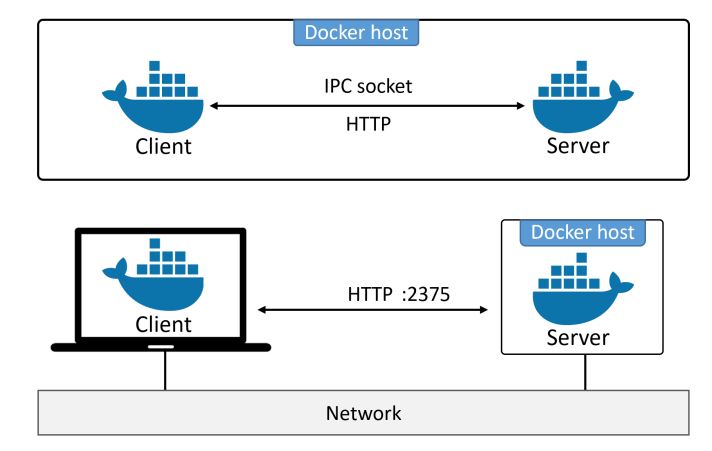

$$ Figure\ 5.5$$

An insecure configuration like this might be suitable for labs, but it’s unacceptable for anything else.

TLS to the rescue!

Docker lets you force the client and daemon to only accept network connections that are secured with TLS. This
is recommended for production environments, even if all traffic is traversing trusted internal networks.

You can secure both the client and the daemon. Securing the client forces the client to only connect to Docker
daemons with certificates signed by a trusted Certificate Authority (CA). Securing the daemon forces the daemon
to only accept connections from clients presenting certificates from a trusted CA. A combination of both modes
offers the most security.

We’ll use a simple lab environment to walk through the process of configuring Doer for daemon mode and
client mode TLS.


#### Lab setup

We’ll use the lab setup shown in Figure 5.6 for the remainder of the examples. Your lab will look different, but
it’s vital that the client and daemon can resolve each other by name.

<img src="figure56.png" width=1920 height=1080 />

$$ Figure\ 5.6\ Sample\ lab\ setup $$
    
The high-level process will be as follows:
1. Configure a CA and certificates
2. Create a CA
3. Create and sign keys for the Daemon
4. Create and sign keys for the Client
5. Distribute keys
6. Configure Docker to use TLS
7. Configure daemon mode
8. Configure client mode

##### Create a CA (self-signed certs)

You only need to complete this step if you are following along in a lab and don’t already have a CA. Also, the CA
we’re building here is to help demonstrate how to configure Docker, we’re not attempting to build something
production-grade.

Run the following commands from the CA node in the lab.

1. Create a new private key for the CA. 
* the cmd:  openssl genrsa -aes256 -out ca-key.pem 4096

* You’ll set a passphrase as part of the operation. Don’t forget it!

* You’ll have a new file in your current directory called ca-key.pem. This is the CA’s private key.

2. Use the CA’s private key to generate a public key (certificate).
* cmd:  openssl req -new -x509 -days 730 -key ca-key.pem -sha256 -out ca.pem

* You’ll need to enter the passphrase from the previous step. 

* This has added a second file to your working directory called ca.pem. This is the CA’s public key, a.k.a. “certificate”.


You now have two files in your current directory: ca-key.pem and ca.pem. these are the CA’s key-pair and form
the identity of the CA. At this point, the CA is ready to use

##### Create a key-pair for the daemon
We’ll generate a new key-pair for the Docker daemon on node3. It’s a four-step process:
1. Create the private key
2. Create the signing request
3. Add IP addresses and make it valid for server authorization
4. Generate the certificate

###### Let's do it
1. Create the Private Key for the deamon
    * Create a new file in your working directory: called daemon-key.pem. This is the private key for the daemon node.
    * cmd: openssl genrsa -out daemon-key.pem 4096
2. Create a certificate signing request (CSR) for the CA to create and sign a certificate for the daemon. Be sure to use the correct DNS name for your daemon node. The example uses node3.
    * cmd: openssl req -subj "CN=node3" -sha256 -new -key deamon-key.pem -out deamon.csr
    * You now have a fourth file in your working directory. This one is the CSR and it is called daemon.csr
3. This step creates a file that tells the CA to add a couple of extended attributes to the daemon’s certificate when it signs it. These add the daemon’s DNS name and IP address, as well as configure the certificate to be valid for server authentication.
    * subjectAltName = DNS:node3, IP:10.0.0.12, extendedKeyUsage = serverAuth



##### Benefit
Having all of the logic and code to start and manage containers removed from the daemon means that the entire
container runtime is decoupled from the Docker daemon. We sometimes call this “daemonless containers”, and
it makes it possible to perform maintenance and upgrades on the Docker daemon without impacting running
containers!

In the old model, where all of container runtime logic was implemented in the daemon, starting and stopping
the daemon would kill all running containers on the host. This was a huge problem in production environments
— especially when you consider how frequently new versions of Doer are released! Every daemon upgrade
would kill all containers on that host — not good!

Fortunately, this is no longer a problem.


#### Shim
Some of the diagrams in the chapter have shown a shim component.

The shim is integral to the implementation of daemonless containers - decoupling
running containers from the daemon for things like daemon upgrades).

We mentioned earlier that containerd uses runc to create new containers. In fact, it forks a new instance of runc
for every container it creates. However, once each container is created, the parent runc process exits. This means
we can run hundreds of containers without having to run hundreds of runc instances.

Once a container’s parent runc process exits, the associated containerd-shim process becomes the container’s
parent. Some of the responsibilities the shim performs as a container’s parent include:

1. Keeping any STDIN and STDOUT streams open so that when the daemon is restarted, the container doesn’t terminate due to pipes being closed etc
2. Reports the container’s exit status back to the daemon.

##### How it’s implemented on Linux
On a Linux system, the components we’ve discussed are implemented as separate binaries as follows:
1. dockerd (the Docker daemon)
2. docker-containerd (containerd)
3.  docker-containerd-shim (shim)
4. docker-runc (runc)

You can see all of these on a Linux system by running a ps command on the Docker host. Obviously, some of
them will only be present when the system has running containers.

##### What’s the point of the daemon
With all of the execution and runtime code stripped out of the daemon you might be asking the question: “what
is left in the daemon?”

Obviously, the answer to this question will change over time as more and more functionality is stripped out
and modularized. However, at the time of writing, some of the major functionality that still exists in the
daemon includes; image management, image builds, the REST API, authentication, security, core networking,
and orchestration.



#### Securing client and daemon communication
###### How to secure the daemon over the network?
Docker implements a client-server model.
1. The client component implements the CLI
2. The server (daemon) component implements the functionality, including the public-facing REST API

The client -> docker or docker.exe

The deamon -> docherd or dockerd.exe

A default installation puts them on the same host and configures them to communicate over a local
IPC socket:
• /var/run/docker.sock on Linux
• //./pipe/docker_engine on Windows


It’s also possible to configure them to communicate over the network. By default, network communication occur
over an unsecured HTTP soet on port 2375/tcp.

<img src="figure55.png" width=1920 height=1080 />

$$ Figure\ 5.5$$

An insecure configuration like this might be suitable for labs, but it’s unacceptable for anything else.

TLS to the rescue!

Docker lets you force the client and daemon to only accept network connections that are secured with TLS. This
is recommended for production environments, even if all traffic is traversing trusted internal networks.

You can secure both the client and the daemon. Securing the client forces the client to only connect to Docker
daemons with certificates signed by a trusted Certificate Authority (CA). Securing the daemon forces the daemon
to only accept connections from clients presenting certificates from a trusted CA. A combination of both modes
offers the most security.

We’ll use a simple lab environment to walk through the process of configuring Docker for daemon mode and
client mode TLS.


#### Lab setup

We’ll use the lab setup shown in Figure 5.6 for the remainder of the examples. Your lab will look different, but
it’s vital that the client and daemon can resolve each other by name.

<img src="figure56.png" width=1920 height=1080 />

$$ Figure\ 5.6\ Sample\ lab\ setup $$
    
The high-level process will be as follows:
1. Configure a CA and certificates
2. Create a CA
3. Create and sign keys for the Daemon
4. Create and sign keys for the Client
5. Distribute keys
6. Configure Docker to use TLS
7. Configure daemon mode
8. Configure client mode

##### Create a CA (self-signed certs)

You only need to complete this step if you are following along in a lab and don’t already have a CA. Also, the CA
we’re building here is to help demonstrate how to configure Docker, we’re not attempting to build something
production-grade.

Run the following commands from the CA node in the lab.

1. Create a new private key for the CA. 
* the cmd:  openssl genrsa -aes256 -out ca-key.pem 4096

* You’ll set a passphrase as part of the operation. Don’t forget it!

* You’ll have a new file in your current directory called ca-key.pem. This is the CA’s private key.

2. Use the CA’s private key to generate a public key (certificate).
* cmd:  openssl req -new -x509 -days 730 -key ca-key.pem -sha256 -out ca.pem

* You’ll need to enter the passphrase from the previous step. 

* This has added a second file to your working directory called ca.pem. This is the CA’s public key, a.k.a. “certificate”.


You now have two files in your current directory: ca-key.pem and ca.pem. ese are the CA’s key-pair and form
the identity of the CA. At this point, the CA is ready to use

##### Create a key-pair for the daemon
We’ll generate a new key-pair for the Docker daemon on node3. It’s a four-step process:
1. Create the private key
2. Create the signing request
3. Add IP addresses and make it valid for server authorization
4. Generate the certificate

###### Let's do it
1. Create the Private Key for the deamon
    * Create a new file in your working directory: called daemon-key.pem. This is the private key for the daemon node.
    * cmd: openssl genrsa -out daemon-key.pem 4096
2. Create a certificate signing request (CSR) for the CA to create and sign a certificate for the daemon. Be sure to use the correct DNS name for your daemon node. The example uses node3.
    * cmd: openssl req -subj "CN=node3" -sha256 -new -key deamon-key.pem -out deamon.csr
    * You now have a fourth file in your working directory. This one is the CSR and it is called daemon.csr
3. This step creates a file that tells the CA to add a couple of extended attributes to the daemon’s certificate when it signs it. These add the daemon’s DNS name and IP address, as well as configure the certificate to be valid for server authentication.
    * subjectAltName = DNS:node3, IP:10.0.0.12, extendedKeyUsage = serverAuth
    * cmd: echo



<img src="figure57.png" width=1920 height=1080 />